In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all words in words.txt
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32084


In [3]:
# building vocab of chars and mapping from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Dataset Creation

In [4]:
# Create the dataset
block_size = 3
X, Y =[], []
for w in words:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, Y.shape

(torch.Size([228522, 3]), torch.Size([228522]))

## Building embedding lookup table C
* Earlier we had 27 chars with their representation in 27 dim
* We will reduce the dim to 2 i.e 27 chars with representation of 2dim

In [6]:
C = torch.randn((27, 2))
C[5]

tensor([-0.5158,  1.9160])

In [7]:
F.one_hot(torch.tensor(5), num_classes = 27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [8]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-0.5158,  1.9160])

In [9]:
X.shape, Y.shape

(torch.Size([228522, 3]), torch.Size([228522]))

In [10]:
emb = C[X]
print(emb.shape)   # input shape
#emb

torch.Size([228522, 3, 2])


## Hidden Layer implementation W1
* Need to transform input 32, 3, 2 into something 32,6 so that multiplication is valid

In [11]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([228522, 6])

In [13]:
emb[:,1,:].shape

torch.Size([228522, 2])

In [14]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228522, 6])

In [16]:
#emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

### Hidden layer h

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228522, 100])

In [18]:
h

tensor([[-0.8995,  0.9928, -0.9697,  ...,  0.7238, -0.1298,  0.9883],
        [-0.9999,  0.9997, -0.7371,  ..., -0.9986, -0.4019,  0.9997],
        [ 0.4652,  0.9937,  0.9799,  ...,  0.9941, -0.0584,  0.8692],
        ...,
        [-0.9804, -0.7210, -0.1487,  ..., -1.0000,  0.6977, -0.9618],
        [ 0.9994, -0.9929,  0.1727,  ..., -0.8716,  0.0052, -0.8916],
        [-0.9804, -0.2014, -0.3786,  ..., -1.0000,  0.8605, -0.9987]])

## Output Layer

In [19]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [20]:
logits = h @ W2+b2
logits.shape

torch.Size([228522, 27])

In [21]:
# Softmax
counts = logits.exp()
probs = counts / counts.sum(1, keepdims = True)
#probs[0].sum()

In [22]:
Y.shape

torch.Size([228522])

In [23]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [26]:
#probs[torch.arange(32), Y]

In [28]:
# # Negative log likelihood
# loss = -probs[torch.arange(32), Y].log().mean()
# loss

## SUMMARISING

In [29]:
X.shape , Y.shape

(torch.Size([228522, 3]), torch.Size([228522]))

In [93]:
g = torch.Generator().manual_seed(2147483647)
#----Embedding layer-------
C = torch.randn((27,2), generator = g)

#----Hidden Layer -------
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)

# ----Output Layer--------
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]

In [94]:
print(f"Number of parameters of this model : {sum(p.nelement() for p in parameters)}")

Number of parameters of this model : 3481


In [95]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
logits = h @ W2+b2
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdims = True)
# loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5028)

In [96]:
F.cross_entropy(logits, Y)

tensor(19.5028)

## Training
#### Now we want to minimise this particular loss

In [97]:
for p in parameters : 
    p.requires_grad = True

In [98]:
# for _ in range(10): 
#     # Forward Pass
#     emb = C[X] 
#     h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
#     logits = h @ W2+b2
#     loss = F.cross_entropy(logits, Y)
#     print(f'Loss : {loss.item()}')

#     # Backward Pass
#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     # Update
#     for p in parameters:
#         p.data += -0.1 * p.grad

It takes a long time to calculate loss as we are going throug all. We should go through batches and calculate loss

### Mini batch training 

In [99]:
torch.randint(0, X.shape[0], (32,)) # this is the random indexes of our dataset

tensor([ 91668, 149928, 105866, 209235,  32264, 110963,   8122, 149097,  13567,
         75996, 133331, 202422, 157818, 154634, 103207, 198254, 176608, 149097,
         78636,   6002,  34002, 205042, 132544,  10125, 208663,   2343, 112115,
        193406, 135562,  52939,  23044, 196452])

In [100]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents
lrs = 10**lre
#lrs # candidates for learning rates

In [91]:
lri = []
lossi = []
for i in range(1000): 
    
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # Forward Pass
    emb = C[X[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
    
#print(f'Loss : {loss.item()}')

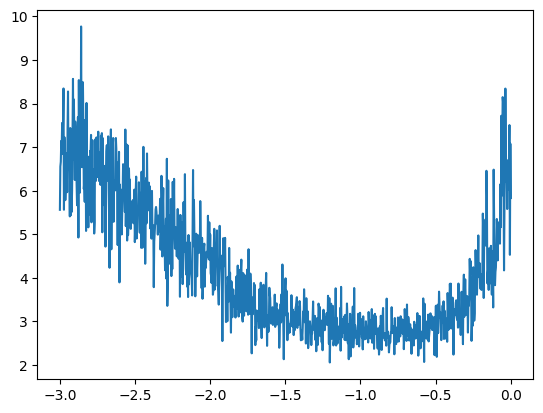

In [92]:
plt.plot(lri, lossi)

In [111]:
lri = []
lossi = []
for i in range(9000): 
    
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    # Forward Pass
    emb = C[X[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    #lossi.append(loss.item())
    
#print(f'Loss : {loss.item()}')

### best lr exponent comes out to be -1 that is lr = 0.1

In [112]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3168, grad_fn=<NllLossBackward0>)

### Best loss till now than bigram 2.31 < 2.45

## Train test and val split

In [142]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182807, 3]) torch.Size([182807])
torch.Size([22865, 3]) torch.Size([22865])
torch.Size([22850, 3]) torch.Size([22850])


In [143]:
len(words), n1, n2

(32084, 25667, 28875)

In [144]:
Xtr.shape, Ytr.shape

(torch.Size([182807, 3]), torch.Size([182807]))

In [145]:
g = torch.Generator().manual_seed(2147483647)
#----Embedding layer-------
C = torch.randn((27,2), generator = g)

#----Hidden Layer -------
W1 = torch.randn((6, 300), generator = g)
b1 = torch.randn(300, generator = g)

# ----Output Layer--------
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters of this model : {sum(p.nelement() for p in parameters)}")

for p in parameters : 
    p.requires_grad = True

Number of parameters of this model : 10281


In [ ]:
lri = []
lossi = []
stepi = []
for i in range(30000): 
    
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # Forward Pass
    emb = C[Xtr[ix]]  # 32,3,2
    h = torch.tanh(emb.view(-1, 6) @ W1+b1) #(32, 100)
    logits = h @ W2+b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'Loss : {loss.item()}')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    #lr = lrs[i]
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
    
print(f'Loss : {loss.item()}')

In [ ]:
plt.plot(stepi, lossi)

### Evaluating the loss through the Val set
Not ovefitting but underfitting

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1+b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ytr)
loss